# Variational Classifier

Variational Quantum Classifier is a quantum circuit that can be trained from original labelled data to classify new data samples. First we will classify simple parity function, then move on to more complicated iris dataset.

In [1]:
import pennylane as qml
import torch
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.operation import Tensor

### 1. Classifying Parity function

Parity function takes in 4 bits and returns 1(0) when there is odd(even) number of 1. We start by loading the dataset.

In [2]:
data = np.loadtxt("parity.txt")
X = np.array(data[:,:-1])
Y = np.array(data[:, -1])
Y = Y * 2 - np.ones(len(Y))


for i in range(len(X)):
    print('X = {}, Y = {: d}'.format(X[i], int(Y[i])))

X = [0. 0. 0. 0.], Y = -1
X = [0. 0. 0. 1.], Y =  1
X = [0. 0. 1. 0.], Y =  1
X = [0. 0. 1. 1.], Y = -1
X = [0. 1. 0. 0.], Y =  1
X = [0. 1. 0. 1.], Y = -1
X = [0. 1. 1. 0.], Y = -1
X = [0. 1. 1. 1.], Y =  1
X = [1. 0. 0. 0.], Y =  1
X = [1. 0. 0. 1.], Y = -1
X = [1. 0. 1. 0.], Y = -1
X = [1. 0. 1. 1.], Y =  1
X = [1. 1. 0. 0.], Y = -1
X = [1. 1. 0. 1.], Y =  1
X = [1. 1. 1. 0.], Y =  1
X = [1. 1. 1. 1.], Y = -1


Now we prepare variational circuit. Classical data input(X) is embedded using BasisEmbedding method.

In [3]:
n_qubits = 4
dev = qml.device("default.qubit", wires = n_qubits)
def statepreparation(x):
    qml.BasisState(x, wires = [0,1,2,3])

def layer(W):
    qml.Rot(*W[0], wires = 0)
    qml.Rot(*W[1], wires = 1)
    qml.Rot(*W[2], wires = 2)
    qml.Rot(*W[3], wires = 3)
    
    qml.CNOT(wires = [0,1])
    qml.CNOT(wires = [1,2])
    qml.CNOT(wires = [2,3])
    qml.CNOT(wires = [3,0])

@qml.qnode(dev, interface = "torch", diff_method = "parameter-shift")
def circuit(weights, x):
    statepreparation(x)
    for W in weights:
        layer(W)    
    return qml.expval(qml.PauliZ(0))

We can add bias in a classical function,

In [4]:
def Variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

Define loss function (used square loss in this problem) and accuracy test.

In [5]:
def square_loss(labels, predictions):
    loss = 0
    for i in range(len(labels)):
        loss += (predictions[i] - labels[i])**2
    loss / len(labels)
    return loss

def accuracy(labels, predictions):
    accuracy = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-2:
            accuracy = accuracy + 1
    accuracy = accuracy /len(labels)
    return accuracy

Now we optimize the circuit,

In [6]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
steps = 200

In [7]:
def parity_circuit_optimize(num_layers, steps):
    
    weights = 0.01 * np.random.randn (num_layers, num_qubits, 3)
    weights_torch = torch.tensor(weights, requires_grad = True)
    bias_torch = torch.tensor(0.0)
    
    loss_history = []
    opt = torch.optim.Adam([weights_torch, bias_torch], lr = 0.1)
    batch_size = 5
    
    for i in range(steps):
        
        batch_index = np.random.choice(len(X), size = batch_size)
        
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        
        X_batch_torch = torch.tensor(X_batch, requires_grad = False)
        Y_batch_torch = torch.tensor(Y_batch, requires_grad = False)
        
        
        opt.zero_grad()
        predictions = torch.stack([Variational_classifier(weights_torch, bias_torch, x) for x in X_batch_torch])
        loss = square_loss(predictions, Y_batch_torch)
        current_loss = loss.detach().numpy().item()
        loss_history.append(current_loss)
        loss.backward()
        
        if i % 10 == 0:
            print('steps ', i, ', loss', current_loss)
        
        opt.step()
        
    return weights_torch, bias_torch, loss_history

In [8]:
weights_torch_trained, bias_torch_trained, loss_history = parity_circuit_optimize(num_layers, steps)

steps  0 , loss 11.99557642046123
steps  10 , loss 3.94989016832672
steps  20 , loss 0.1701052593780992
steps  30 , loss 0.17045122480922842
steps  40 , loss 0.05683354087324432
steps  50 , loss 0.0026986061264351155
steps  60 , loss 0.0012003070329231025
steps  70 , loss 0.0010615553884226964
steps  80 , loss 0.0006776307642825416
steps  90 , loss 0.0003918515351881998
steps  100 , loss 0.00022525449654794104
steps  110 , loss 0.0001232940370053039
steps  120 , loss 8.355328400711438e-05
steps  130 , loss 5.6041626573768125e-05
steps  140 , loss 4.053508750437118e-05
steps  150 , loss 3.2859187626222086e-05
steps  160 , loss 2.7077865321274045e-05
steps  170 , loss 2.0956197304874103e-05
steps  180 , loss 1.6496512550007952e-05
steps  190 , loss 1.5388608134770693e-05


In [9]:
X_torch = torch.tensor(X, requires_grad = False)
Y_torch = torch.tensor(Y, requires_grad = False)

predictions = torch.stack([Variational_classifier(weights_torch_trained, bias_torch_trained, x) for x in X_torch])
print(predictions)
print(Y_torch)
acc = accuracy(Y_torch, predictions)
print(acc)

tensor([-0.9983,  0.9985,  0.9985, -0.9983,  0.9985, -0.9983, -0.9983,  0.9985,
         0.9983, -0.9985, -0.9985,  0.9983, -0.9985,  0.9983,  0.9983, -0.9985],
       dtype=torch.float64, grad_fn=<StackBackward>)
tensor([-1.,  1.,  1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1.,
         1., -1.], dtype=torch.float64)
1.0


## 2. Iris Classifier

In [10]:
dev = qml.device("default.qubit", wires = 2)

First start by loading the Iris dataset.

In [11]:
data = np.loadtxt("iris.txt")
X = data[:,0:4]


normalization = np.sqrt(np.sum(X**2, -1))
X = (X.T / normalization).T


Y = data[:, -1]

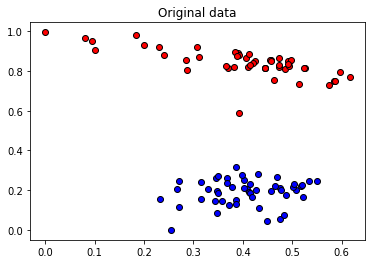

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()



From Iris dataset, we are going to separate training data and test data.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print(X_train[0], Y_train[0])
print(len(X_train))
print(len(Y_train))

[0.32963426 0.20602141 0.82408564 0.41204282] 1.0
75
75


### 2.1 Data Embedding

We use amplitude embedding for this problem. Data can be embedded into amplitudes of the quantum state with following procedure.

In [16]:
def get_angle(x):
    
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2)) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12)
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2)) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12)
    beta2 = 2 * np.arcsin(np.sqrt(x[2] ** 2 + x[3] **2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] **2 + x[3] **2))
    
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [17]:
def statepreparation(a):
    qml.RY(a[0], wires = 0)
    
    qml.CNOT(wires = [0,1])
    qml.RY(a[1], wires = 1)
    qml.CNOT(wires = [0,1])
    qml.RY(a[2], wires = 1)
    
    qml.PauliX(wires = 0)
    qml.CNOT(wires = [0,1])
    qml.RY(a[3], wires = 1)
    qml.CNOT(wires = [0,1])
    qml.RY(a[4], wires = 1)
    qml.PauliX(wires = 0)

In [18]:
x = np.array([0.539, 0.795, 0.278, 0.0])
ang = get_angle(x)

@qml.qnode(dev)
def test(angles):
    statepreparation(angles)
    return qml.expval(qml.PauliZ(0))

test(ang)
np.real(dev.state)

tensor([0.55341699, 0.78513215, 0.27802363, 0.        ], requires_grad=True)

Or built in pennylane embedding templates can be used.

In [19]:
from pennylane.templates.embeddings import AmplitudeEmbedding

@qml.qnode(dev)
def test(x):
    AmplitudeEmbedding(x, wires = [0,1], normalize=True)
    return qml.expval(qml.PauliZ(0))

In [20]:
test(x)
np.real(dev.state)

tensor([0.53904582, 0.79506758, 0.27802363, 0.        ], requires_grad=True)

### 2.2 Variational Classifier

In [21]:
def layer(W):
    qml.Rot(*W[0], wires = 0)
    qml.Rot(*W[1], wires = 1)
    qml.CNOT(wires = [0,1])
    
@qml.qnode(dev, interface = 'torch', diff_method = 'parameter-shift')
def circuit(weights, x):
    AmplitudeEmbedding(x, wires = [0,1], normalize = True)
    
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias



Now we optimize the classifier.

np.random.seed(0)
num_layers = 6
batch_size = 5
steps = 100

In [38]:
np.random.seed(0)
num_layers = 6
batch_size = 10
steps = 150

In [39]:
def optimize_classifier(steps, num_layers):
    weights = np.random.randn(num_layers, 2, 3) * 0.01
    weights_torch = torch.tensor(weights, requires_grad = True)
    bias_torch = torch.tensor(0.0, requires_grad = True)
    
    loss_history = []
    opt = torch.optim.Adam([weights_torch, bias_torch], lr = 0.1)
    
    for i in range(steps):
        batch_index = np.random.choice(len(X_train), size = batch_size)
        
        X_batch = X_train[batch_index]
        Y_batch = Y_train[batch_index]
        
        X_batch_torch = torch.tensor(X_batch, requires_grad = False)
        Y_batch_torch = torch.tensor(Y_batch, requires_grad = False)
        
        def closure():
            opt.zero_grad()
            preds = torch.stack([variational_classifier(weights_torch, bias_torch, x) for x in X_batch_torch])
            loss = square_loss(preds, Y_batch_torch)
            current_loss = loss.detach().numpy().item()
            if i % 10 == 0:
                print("steps ", i, " loss", current_loss)
            loss_history.append(loss)
            loss.backward()
            return loss
        
        opt.step(closure)
    return weights_torch, bias_torch, loss_history

In [40]:
trained_weights_torch, trained_bias_torch, loss_history = optimize_classifier(steps, num_layers)

steps  0  loss 30.457022072088026
steps  10  loss 1.1541648153736095
steps  20  loss 0.9489440080299396
steps  30  loss 0.7511141997659327
steps  40  loss 0.8312739520510792
steps  50  loss 0.41526550491704706
steps  60  loss 0.7224791468807037
steps  70  loss 0.5103029988468331
steps  80  loss 0.6029966508505047
steps  90  loss 0.6152051275700279
steps  100  loss 0.5318072510090803
steps  110  loss 0.589220421973285
steps  120  loss 0.5826051311527691
steps  130  loss 0.6221330082646681
steps  140  loss 0.75577522119875


In [41]:
def accuracy_test(preds, Y):
    accuracy = 0
    for p,y in zip(preds, Y):
        if abs(p - y) < 1e-3:
            accuracy += 1
    accuracy / len(Y)
    return accuracy
        

In [42]:
X_test_torch = torch.tensor(X_test)
Y_test_torch = torch.tensor(Y_test)

preds = torch.stack([variational_classifier(trained_weights_torch, trained_bias_torch, x)for x in X_test_torch])
accuracy = accuracy_test(preds, Y_test_torch)
print(preds)
print(Y_test_torch)

tensor([ 0.6881,  0.6098, -0.7748,  0.5840,  0.7257,  0.7826,  0.5814,  0.6412,
        -0.8312,  0.8883, -0.8868,  0.5194, -0.6502, -0.9014,  0.6985, -0.1153,
         0.6566,  0.6266,  0.7274, -0.6910,  0.6704, -0.9119, -0.8225, -0.9759,
        -0.9631], dtype=torch.float64, grad_fn=<StackBackward>)
tensor([ 1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,
         1., -1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.],
       dtype=torch.float64)


In [43]:
print(accuracy)

0
